In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, MaxPooling2D, BatchNormalization, Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2023-12-21 21:18:03.374370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 21:18:04.022901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Image Specifications
folder_path = "../dataset/MMAFEDB/"
image_dimension = (48, 48)
image_depth = 3
image_color_mode = 'rgb'
batch_size = 64

# Data Augmentation for Training Set
datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescaling for Validation Set
datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(
    folder_path + "train",
    target_size=image_dimension,
    color_mode=image_color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_set = datagen_val.flow_from_directory(
    folder_path + "test",
    target_size=image_dimension,
    color_mode=image_color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the total number of images in the training set
total_images_train = train_set.n
print("Total images in training set:", total_images_train)
# Get the total number of images in the training set
total_images_test = test_set.n
print("Total images in test set:", total_images_test)

Found 92968 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.
Total images in training set: 92968
Total images in test set: 17356


In [3]:
# Create sequential model
model = Sequential()

# Input size 48 x 48 x image_depth [1 or 3]
model.add(Conv2D(filters = 32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, image_depth)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# The final dense layer before is important, too less filters means too little information can be extracted before mapping to the last layer. 2x 512 performs little worse than 1x 1024
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

2023-12-21 21:18:06.762550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 21:18:06.789037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 21:18:06.789281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                        

In [4]:
# Define hyperparameters
epochs = 50

# Set up model checkpoint
checkpoint = ModelCheckpoint(
    "model_weights2.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)
callbacks_list = [checkpoint]

# Train the model
history = model.fit(
    train_set,
    validation_data=test_set,
    steps_per_epoch=total_images_train // batch_size,
    validation_steps=total_images_test // batch_size,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/50


2023-12-21 21:18:08.695783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-21 21:18:09.779444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2023-12-21 21:18:10.582619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-21 21:18:10.586650: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4164e5bfc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-21 21:18:10.586674: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-12-21 21:18:10.590102: I tensorflow/compiler/mlir/tensorflow/utils/du

1452/1452 [==============================] - ETA: 0s - loss: 1.6662 - accuracy: 0.4605
Epoch 1: val_accuracy improved from -inf to 0.50923, saving model to model_weights2.h5


/home/fox/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1452/1452 [==============================] - 59s 37ms/step - loss: 1.6662 - accuracy: 0.4605 - val_loss: 1.8383 - val_accuracy: 0.5092
Epoch 2/50
1451/1452 [============================>.] - ETA: 0s - loss: 1.2982 - accuracy: 0.5649
Epoch 2: val_accuracy did not improve from 0.50923
1452/1452 [==============================] - 53s 37ms/step - loss: 1.2982 - accuracy: 0.5649 - val_loss: 1.3738 - val_accuracy: 0.5090
Epoch 3/50
1452/1452 [==============================] - ETA: 0s - loss: 1.1281 - accuracy: 0.6072
Epoch 3: val_accuracy improved from 0.50923 to 0.51983, saving model to model_weights2.h5
1452/1452 [==============================] - 53s 36ms/step - loss: 1.1281 - accuracy: 0.6072 - val_loss: 1.3874 - val_accuracy: 0.5198
Epoch 4/50
1451/1452 [============================>.] - ETA: 0s - loss: 1.0685 - accuracy: 0.6266
Epoch 4: val_accuracy did not improve from 0.51983
1452/1452 [==============================] - 53s 37ms/step - loss: 1.0685 - accuracy: 0.6266 - val_loss: 1.41

In [5]:
# NOT CHANGED! # DO NOT USE LIKE THIS
model.save_weights("./model2.h5")

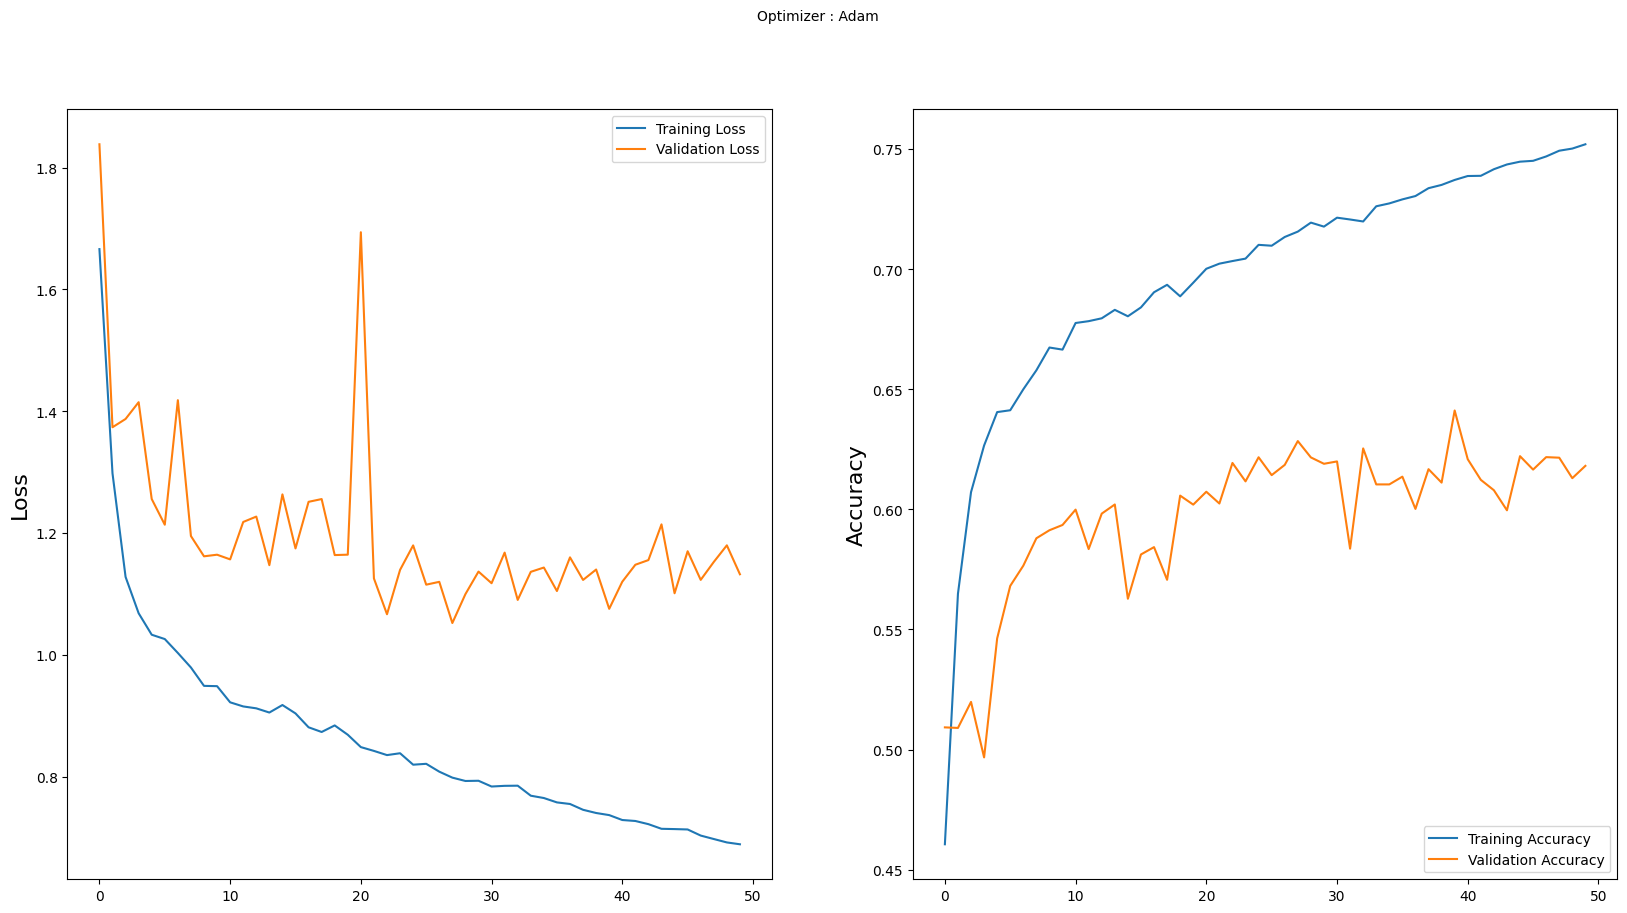

In [6]:
# NOT CHANGED # DO NOT USE LIKE THIS!
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [7]:
# Get predictions using the generator
predictions = model.predict(test_set)

272/272 [==============================] - 3s 12ms/step


In [8]:
import numpy as np
# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

array([4, 4, 0, ..., 4, 4, 6])

In [9]:
class_indices_mapping = train_set.class_indices
actual_labels = test_set.classes

index_to_class_mapping = {v: k for k, v in class_indices_mapping.items()}
predicted_class_labels = [index_to_class_mapping[index] for index in predicted_labels]
predicted_class_labels

# Compare the actual labels with the predicted labels
for actual, predicted in zip(actual_labels, predicted_labels):
    print(f"Actual: {actual}, Predicted: {predicted}")
    


Actual: 0, Predicted: 4
Actual: 0, Predicted: 4
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 2
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 5
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 4
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 4
Actual: 0, Predicted: 0
Actual: 0, Predicted: 5
Actual: 0, Predicted: 0
Actual: 0, Predicted: 5
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 3
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 4
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 5
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 6
Actual: 0, Predi

In [10]:
# Assuming you have actual labels and predicted labels

# Calculate the number of correct predictions
correct_predictions = np.sum(actual_labels == predicted_labels)

# Calculate the total number of predictions
total_predictions = len(actual_labels)

# Calculate the number of incorrect predictions
incorrect_predictions = total_predictions - correct_predictions

# Calculate the accuracy
accuracy = correct_predictions / total_predictions

# Print the results
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {incorrect_predictions}")
print(f"Total predictions: {total_predictions}")
print(f"Accuracy: {accuracy * 100:.2f}%")


Correct predictions: 10728
Incorrect predictions: 6628
Total predictions: 17356
Accuracy: 61.81%
